In [152]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from konlpy.tag import Twitter
twt = Twitter()
from hanspell import spell_checker
import re
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Kkma
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error

D:\programfiles\anaconda3\envs\pythonopencv\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
df = pd.read_csv('./result/2021-03-10_20-10-56 마켓컬리.csv')
df.head()

In [ ]:
df.describe()

In [ ]:
df = df[['date', 'comment', 'ratings']]

In [ ]:
# for i in range(len(df)) :
#     result = spell_checker.check(df['comment'][i])
#     a= result[1]
#     df['comment'][i] = a

In [ ]:
df['comment']

In [ ]:
def text_cleaning(text):
    hangul = re.compile('[|ㄱ-ㅎ|ㅏ-ㅣ]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [ ]:
# def text_cleaning2(text):
#     hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
#     result = hangul.sub('', text)
#     return result

In [ ]:
df['ko_text'] = df['comment'].apply(lambda x: text_cleaning(x))
df.head()

In [ ]:
# df['ko_text'] = df['ko_text'].apply(lambda x: text_cleaning2(x))
# df.head()

In [ ]:
df['ko_text']

In [ ]:
df.describe()

In [ ]:
# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "./korean_stopwords2.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = Kkma()
    nouns = nouns_tagger.nouns(x)
    
    # 한글자 키워드를 제거합니다.
    nouns = [noun for noun in nouns if len(noun) > 1]
    
    # 불용어를 제거합니다.
    nouns = [noun for noun in nouns if noun not in stopwords]
    
    return nouns

In [ ]:
df['nouns'] = df['ko_text'].apply(lambda x: get_nouns(x))
for i in range(len(df)):
    if not df['nouns'][i]:
        df.drop([i],inplace=True)
        
df.reset_index(inplace=True)
del df['index']
print(df.shape)
df.head()

In [ ]:
all_words = []
satisfaction= []
for i in range(len(df)):
    words = df['nouns'][i]
    words_arr = []
    for n in words:
        words_arr.append(n)
        satisfaction.append(df['ratings'].iloc[i])
    all_words.extend(words_arr)
    
all_words_df = pd.DataFrame({"words":all_words, "satisfaction":satisfaction, "count":len(all_words)*[1]})
all_words_df.head()        
    

In [ ]:
words_satisfaction = all_words_df.groupby('words').mean()['satisfaction']
words_count = all_words_df.groupby('words').sum()['count']
words_df = pd.concat([words_satisfaction, words_count], axis=1)
words_df.head()

In [ ]:
words_df = words_df.loc[words_df['count']>=3]
words_df.sort_values('satisfaction', ascending=False)

In [ ]:
words_df.sort_values('count')

In [ ]:
all_words_df = pd.DataFrame()

for n in range(len(df)):
    words = df['nouns'][n]
    words_df = pd.DataFrame()
    for i in words:
        words_df[i] = [1]
        #satisfaction.append(df['ratings'].iloc[i])
    all_words_df = pd.concat([all_words_df, words_df], ignore_index=True)
    
all_words_df.head()   
    

In [ ]:
all_words_df = all_words_df.fillna(0)
all_words_df.head()

In [ ]:
korean_stopwords_path = "./korean_stopwords2.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
nouns_tagger =Kkma()
def text_cleaning(text):
    hangul = re.compile('[|ㄱ-ㅎ|ㅏ-ㅣ]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    tagger = Kkma()
    nouns = nouns_tagger.nouns(result)
    nouns = [x for x in nouns if len(x) >1]
    nouns =[x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer= lambda x : text_cleaning(x))
bow_vect = vect.fit_transform(df['comment'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [ ]:
word_list

In [ ]:
count_list

In [ ]:
bow_vect.shape

In [ ]:
word_count_dict = dict(zip(word_list, count_list))
print(str(word_count_dict)[:100])

In [ ]:
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [ ]:
print(tf_idf_vect[0])

In [ ]:
invert_index_vectorizer = {v:k for k,v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100])

In [ ]:
df.sample(10).head()

In [ ]:
df.ratings.hist()

In [ ]:
def rating_to_label(rating) :
  if rating >3:
    return 1
  else:
    return 0
df['y'] = df['ratings'].apply(lambda x : rating_to_label(x))

In [ ]:
df

In [ ]:
df.y.value_counts()

In [197]:
y= df['y']
X_train,X_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size = 0.2)

In [198]:
print(X_test.shape)

(785, 4815)


# 여기까지 

# 로지스틱 회귀

In [199]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs", max_iter=500)
lr.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(lr.score(X_test, y_test)*100,2)))

Test Accuracy: 80.51%


In [200]:
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Classifier report: \n\n", classification_report(y_test, y_pred_lr))

Logistic Regression Classifier report: 

               precision    recall  f1-score   support

           0       0.33      0.01      0.03       151
           1       0.81      0.99      0.89       634

    accuracy                           0.81       785
   macro avg       0.57      0.50      0.46       785
weighted avg       0.72      0.81      0.73       785



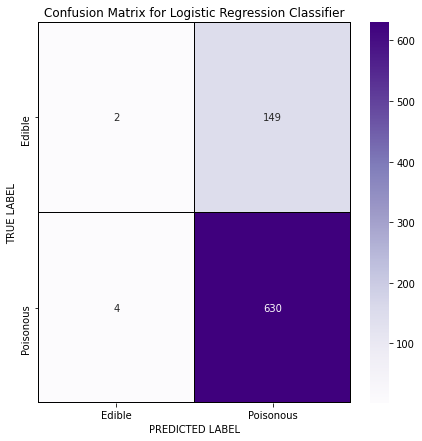

In [201]:
cm = confusion_matrix(y_test, y_pred_lr)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.savefig("lrcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

<BarContainer object of 4815 artists>

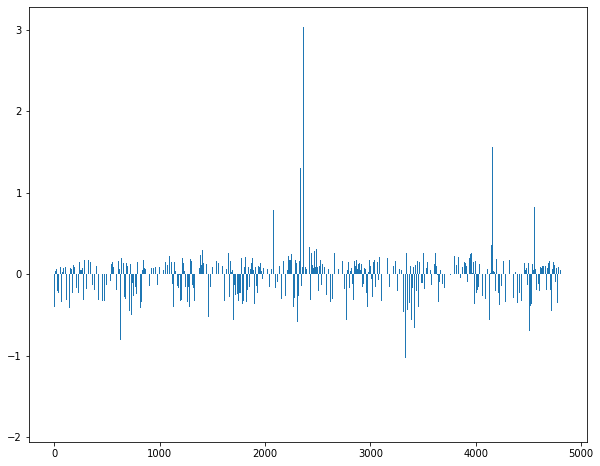

In [202]:
plt.rcParams['figure.figsize'] = [10,8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [203]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(lr.coef_[0])), reverse= False)

In [204]:
for coef in coef_pos_index[:100]:
  print(invert_index_vectorizer[coef[1]],coef[0])

신선 3.0359854966286073
포장 2.382832368400757
유용 2.3082052121468113
품질 1.9662623574918459
간편 1.7496853693187342
제품 1.7333038209783713
식재료 1.694489185286283
배송 1.6353280189892292
재료 1.6352110347156599
퀄리티 1.563220705710427
새벽 1.5542821960916355
소량 1.5460813004848797
신선도 1.4231973526139574
식품 1.303537345982469
친절 1.2112723392156266
고급 1.1929156562565555
상품 1.1762618276543504
편리함 1.1202211188701205
가격 1.0566204516640154
카테고리 1.0159718868701413
신속 0.9577767614551013
적립 0.8678183363845074
정확 0.8601088472981796
포장재 0.8241816755271699
할인 0.8206872106011806
샛별 0.8136385559814792
세일 0.7882350415992356
접근 0.7767724620731349
샛별배송 0.7587063107036278
포인트 0.756071185322721
다음날 0.6985247780749498
할인쿠폰 0.6243908419447961
믿음 0.6143421910361092
재활용 0.5630184924848644
종류 0.5386271726072053
편리하다 0.5371652867847702
담날 0.5364947301229308
신뢰 0.5311902160339893
대체적 0.5243597848222898
금액 0.5133561730943341
포장상태 0.49071338197673514
식자재 0.4886218704410576
메뉴 0.48489583144287973
위로 0.4639397010268476
종이 0.4588819126

In [205]:
for coef in coef_neg_index[:100]:
  print(invert_index_vectorizer[coef[1]],coef[0])

비밀번호 -1.815305646663703
배송불가 -1.6569060433488736
오배송 -1.3796569597007187
배송불가지역 -1.2942285640852584
배송완료 -1.2407445762612588
비쌈 -1.1966381822710637
배송지역 -1.1763432268391134
지연 -1.044237501540917
장바구니 -1.0255213487100447
결제창 -1.019528756646746
과대포장 -0.9973277654575087
아이디어 -0.9859044001066197
대부분 -0.953587872265788
만원이상 -0.9423937928576435
누락 -0.9019881025150331
하세 -0.8987878187236885
반품 -0.8163816041772982
대구 -0.8162302894311172
네이버페이 -0.8124038034747444
원인 -0.7994070177595213
비싸요 -0.786147679302322
인내심 -0.7454428276370577
검색창 -0.7453580020413559
조치 -0.7441806555144956
응답 -0.7396708057281829
신선식품 -0.7365394418503977
정보 -0.7342545566725444
키워드 -0.7090674690325537
현상 -0.7055453221595644
돌기 -0.7040231778432343
하루종일 -0.701578743769058
최악임 -0.7002808788794552
제대 -0.692675229688593
조기마감 -0.6901310132301007
주문가능 -0.6848904681016575
승인 -0.6757647465401042
상품배송 -0.6680435021934085
브랜드 -0.6672498624997286
오류때문 -0.6671565416793828
적인 -0.6644872017557001
통장 -0.6449710825594129
스팸 -0.64313974531703

# 의사결정

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

In [ ]:
y_pred_dt = dt.predict(X_test)
print("Decision Tree Classifier report: \n\n", classification_report(y_test, y_pred_dt))
print("Test Accuracy: {}%".format(round(dt.score(X_test, y_test)*100, 2)))

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Decision Tree Classifier')
#plt.savefig("dtcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
plt.bar(range(len(dt.feature_importances_)), dt.feature_importances_)

In [ ]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(dt.feature_importances_)), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(dt.feature_importances_)), reverse= False)

In [ ]:
for coef in coef_pos_index[:100]:
  print(invert_index_vectorizer[coef[1]], coef[0])

In [ ]:
for coef in coef_neg_index[:100]:
  print(invert_index_vectorizer[coef[1]],coef[0])

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
best_Kvalue = 0
best_score = 0
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    if knn.score(X_test, y_test) > best_score:
        best_score = knn.score(X_train, y_train)
        best_Kvalue = i
        
print("Best KNN Value: {}".format(best_Kvalue))
print("Test Accuracy: {}%".format(round(best_score*100,2)))

In [ ]:
y_pred_knn = knn.predict(X_test)
print("KNN Classifier report: \n\n", classification_report(y_test, y_pred_knn))


In [ ]:
cm = confusion_matrix(y_test, y_pred_knn)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for KNN Classifier')
#plt.savefig("knncm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# svm

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state=42, gamma="auto")
svm.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(svm.score(X_test, y_test)*100, 2)))


In [ ]:
y_pred_svm = svm.predict(X_test)
print("SVM Classifier report: \n\n", classification_report(y_test, y_pred_svm))

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for SVM Classifier')
#plt.savefig("svmcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

# 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Test Accuracy: {}%".format(round(rf.score(X_test, y_test)*100, 2)))

In [ ]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classifier report: \n\n", classification_report(y_test, y_pred_rf))

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Random Forest Classifier');
#plt.savefig("rfcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

In [ ]:
coef_pos_index = sorted(((value, index ) for index, value in enumerate(rf.feature_importances_)), reverse=True)
coef_neg_index = sorted(((value,index) for index, value in enumerate(rf.feature_importances_)), reverse= False)

In [ ]:
for coef in coef_pos_index[:100]:
  print(invert_index_vectorizer[coef[1]], coef[0])

In [ ]:
for coef in coef_neg_index[:100]:
  print(invert_index_vectorizer[coef[1]])

# 라쏘

In [163]:
alpha = 0.00001
lasso = Lasso(alpha=alpha,random_state=42)
lasso.fit(X_train, y_train)
print("X_train,y_train Accuracy: {}%".format(round(lasso.score(X_train, y_train)*100, 2)))
print("X_test,y_test Accuracy: {}%".format(round(lasso.score(X_test, y_test)*100, 2)))
pred = lasso.predict(X_test)
print(f"lasso alpha{alpha} y_test,pred Mse",mean_absolute_error(y_test, pred))
print(f"lasso alpha{alpha} y_test,pred SQRT Mse",np.sqrt(mean_squared_error(y_test, pred)))

X_train,y_train Accuracy: 78.81%
X_test,y_test Accuracy: -28.52%
lasso alpha1e-05 y_test,pred Mse 0.27319634359183964
lasso alpha1e-05 y_test,pred SQRT Mse 0.45774452434483376
